In [178]:
import torch
import torch.nn as nn
from torchvision.transforms import GaussianBlur
import numpy as np
import torchvision as T
import tqdm
import matplotlib.pyplot as plt
from scipy import signal
from torchsummary import summary

In [179]:
import torch
import torch.nn as nn
import numpy as np
import torchvision as T
import tqdm
import matplotlib.pyplot as plt

In [180]:
from keras.datasets.mnist import load_data
(X_train, y_train), (X_test, y_test) = load_data()

X_train = torch.tensor(X_train.reshape((len(X_train),1,28,28))).float()
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test.reshape((len(X_test),1,28,28))).float()
y_test = torch.tensor(y_test)

X_train = X_train/250.
X_test = X_test/250.

In [181]:
Xs=X_train[:10000]
ys = X_train[:10000]

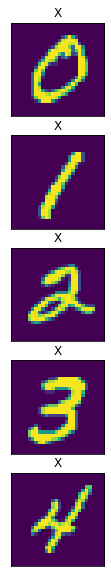

In [182]:
#visualize
plt.figure(figsize=(5,10))
for i in range(1,11,2):
  plt.subplot(5,2,i)
  plt.title("X")
  plt.gca().get_xaxis().set_visible(False)
  plt.gca().get_yaxis().set_visible(False)
  plt.imshow(Xs.detach()[i][0])

In [206]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 =  nn.Conv2d(1,10,3,(2,2))
    self.conv2 =  nn.Conv2d(10,20,3,(2,2))
    self.linear_mean = nn.Linear(6*6*20,50)   #50 dimensional latent space
    self.linear_std = nn.Linear(6*6*20,50)   #50 dimensional latent space

    #self.N = torch.distributions.Normal()

    self.decode_lin = nn.Linear(50,6*6*20)
    self.deconv = nn.ConvTranspose2d(20,15,4,2)
    self.deconv2 = nn.ConvTranspose2d(15,1,2,2)

  def forward(self,x):
    x = self.conv1(x)
    x = nn.functional.relu(x)
    x = self.conv2(x)
    x = nn.functional.relu(x)
    x = torch.reshape(x,(len(x),6*6*20))
    
    mean = self.linear_mean(x)
    std = torch.exp(self.linear_std(x))
    x = mean + torch.randn(50) * std      #sample
    code = x
    kl = (std**2 + mean**2 - torch.log(std) - 1/2).sum()
    x = self.decode_lin(x)
    x = nn.functional.relu(x)
    x = nn.Unflatten(dim=1,unflattened_size=(20,6,6))(x)
    x = self.deconv(x)
    x = nn.functional.relu(x)
    x = self.deconv2(x)
    

    return x,kl,code

In [207]:
model = Model()
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 13, 13]             100
            Conv2d-2             [-1, 20, 6, 6]           1,820
            Linear-3                   [-1, 50]          36,050
            Linear-4                   [-1, 50]          36,050
            Linear-5                  [-1, 720]          36,720
   ConvTranspose2d-6           [-1, 15, 14, 14]           4,815
   ConvTranspose2d-7            [-1, 1, 28, 28]              61
Total params: 115,616
Trainable params: 115,616
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.44
Estimated Total Size (MB): 0.50
----------------------------------------------------------------


In [185]:
def create_the_model():
  model = Model()
  loss = nn.MSELoss()
  opt = torch.optim.Adam(model.parameters(),lr=0.0001)
  return model,loss,opt

In [197]:
def train_the_model(X_train, y_train, mb_size, nb_epochs,k1,k2):
  trainacc = []
  testacc = []
  
  minibatch_X = [X_train[k:k+mb_size] for k in range(0,len(X_train), mb_size)]
  minibatch_y = [y_train[k:k+mb_size] for k in range(0,len(y_train), mb_size)]
  for i in tqdm.trange(nb_epochs):
    for (X_b,y_b) in zip(minibatch_X,minibatch_y):
      pred,kl,_ = model(X_b)
      l = k2 * kl + ((pred-X_b)**2).sum() * k1
      trainacc.append(l.item())

      opt.zero_grad()
      l.backward()
      opt.step()



  return trainacc

In [208]:
Xs=X_train[:10000]
ys = X_train[:10000]
model,loss,opt = create_the_model()
trainacc= train_the_model(Xs,ys,32,30, 1,0.01)

100%|██████████| 30/30 [01:51<00:00,  3.71s/it]


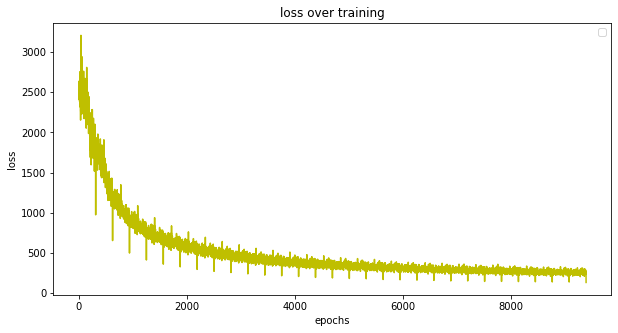

In [211]:
plt.figure(figsize=(10,5))
plt.title("loss over training")
plt.plot(trainacc,"y")
plt.xlabel("epochs")
plt.ylabel("loss")

plt.legend()

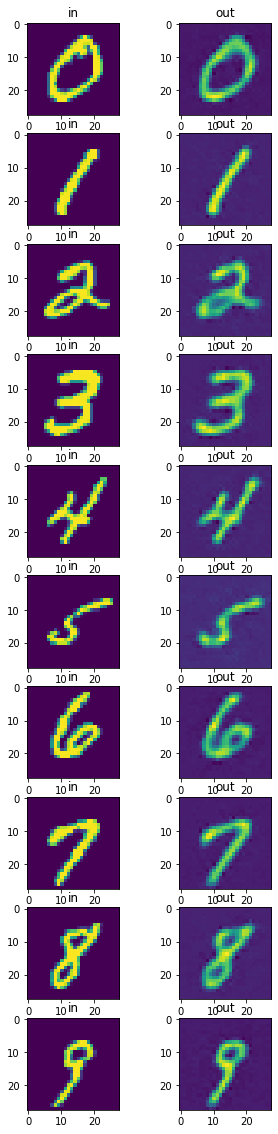

In [210]:
Xs=X_train[:10000]
ys = X_train[:10000]
res = model(Xs[:20])[0]
plt.figure(figsize=(5,20))
for i in range(1,20,2):
  plt.subplot(10,2,i)
  plt.title("in")
  plt.imshow(Xs[i][0].detach().numpy())
  plt.subplot(10,2,i+1)
  plt.title("out")
  plt.imshow(res[i][0].detach().numpy())

In [214]:
#extract the decoder model
dic = dict(model.named_modules())
print(dic)
decoder_model = nn.Sequential(dic["decode_lin"],
                          nn.ReLU(),
                          nn.Unflatten(dim=1,unflattened_size=(20,6,6)),
                          dic["deconv"],
                          nn.ReLU(),
                          dic["deconv2"])

{'': Model(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2))
  (linear_mean): Linear(in_features=720, out_features=50, bias=True)
  (linear_std): Linear(in_features=720, out_features=50, bias=True)
  (decode_lin): Linear(in_features=50, out_features=720, bias=True)
  (deconv): ConvTranspose2d(20, 15, kernel_size=(4, 4), stride=(2, 2))
  (deconv2): ConvTranspose2d(15, 1, kernel_size=(2, 2), stride=(2, 2))
), 'conv1': Conv2d(1, 10, kernel_size=(3, 3), stride=(2, 2)), 'conv2': Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2)), 'linear_mean': Linear(in_features=720, out_features=50, bias=True), 'linear_std': Linear(in_features=720, out_features=50, bias=True), 'decode_lin': Linear(in_features=50, out_features=720, bias=True), 'deconv': ConvTranspose2d(20, 15, kernel_size=(4, 4), stride=(2, 2)), 'deconv2': ConvTranspose2d(15, 1, kernel_size=(2, 2), stride=(2, 2))}


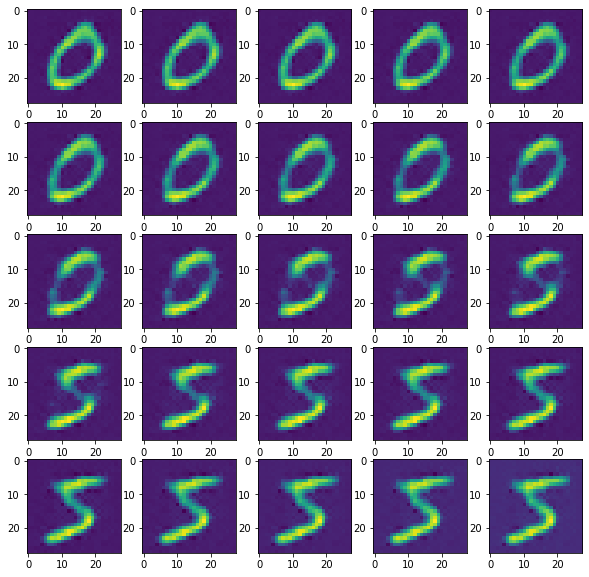

In [215]:
#see smooth transitions in the latent space
codes = model(Xs[:2])[2]
vec1 = codes[0].detach().numpy()
vec2 = codes[1].detach().numpy()
#create interpolation between the two
plt.figure(figsize=(10,10))
interpolation = [i*vec1+(1.-i)*vec2 for i in np.arange(0,1,1./25.)]
interpolation = torch.reshape(torch.tensor(interpolation),(25,50)).float()
res = decoder_model(interpolation)
for (i,vec) in list(zip(range(len(interpolation)),interpolation)):
  i=i+1
  plt.subplot(5,5,i)
  plt.imshow(res[i-1][0].detach().numpy())
